In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import matplotlib
from matplotlib import container
import itertools

In [3]:
original_summary_df = pd.read_csv("csvs/aggregate_summary_all.csv", index_col=0)
summary_df = original_summary_df.copy()
molecules = summary_df["molecule"]
molecule_set = set(molecules)
group_key = "molecule"
g_list = list()

In [4]:
for i, row in summary_df.iterrows():
    if row["engine"] == "gromacs":
        summary_df.at[i, "density-avg"] = row["density-avg"]/1000 
        summary_df.at[i, "density-std"] = row["density-std"]/1000
        summary_df.at[i, "density-sem"] = row["density-sem"]/1000



In [5]:
plt.rcParams["font.family"] = "times" # "helvetica"
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'


# Data cleaning and intial set up

In [ ]:
def mean_confidence_interval(m,se, confidence=0.95):  
    se = np.array(se)
    n = 16
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

In [ ]:
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

In [ ]:
from pprint import pprint

def data_cleaning(molecule_set):
    """Make sure properties of all molecule in the provided molecule_set has been calculated."""
    for molecule in molecule_set:
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
        mol_df["statepoint"] = (
            summary_df["cutoff_style"].map(str)
            + ", "
            + summary_df["long_range_correction"].map(str)
        )
        sp_set = set(mol_df["statepoint"])
        goods = list()
        bads = list()
        
        for engine in mol_df["engine"].unique():
            found_sp = mol_df[mol_df["engine"] == engine].index.tolist()
            if len(found_sp) == len(set(mol_df["statepoint"])):
                goods.append((engine, found_sp))
            else:
                mol_df.drop(axis=0, labels=found_sp, inplace=True)
                bads.append((engine, found_sp))
        print(molecule)
        if goods:
            print(f"\tPassed: {[good[0] for good in goods]}")
        if bads:
            print(f"\tFailed: {[bad[0] for bad in bads]}")

data_cleaning(molecule_set)

waterSPCE
	Passed: ['lammps-VU', 'cassandra', 'mcccs', 'gromacs', 'hoomd', 'gomc']
methaneUA
	Passed: ['gomc', 'lammps-VU', 'cassandra', 'hoomd', 'gromacs', 'mcccs']


# Style set up

In [ ]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


In [34]:
molecules = ["methaneUA", "waterSPCE"]
all_engine_orders = (
    "lammps-VU", 
    "gromacs", 
    "hoomd", 
    "mcccs", 
    "gomc", 
    "cassandra")

#ylims
ylims = {
    "methaneUA": (355, 385), 
    "waterSPCE": (980, 1000),
}

deviation_lims = {
    "methaneUA": 1.5, 
    "waterSPCE": 0.75, 
}

# Colors
symbols = {}
symbols["cassandra"] = "o"
symbols[ "mcccs"] = "^"
symbols["gomc"] = "s"
symbols["gromacs"] = "p" 
symbols[ "hoomd"] = "v" 
symbols[ "lammps-VU"] = "D"
#symbols[ "LAMMPS-UD"] = ">"

colors = {}
colors["cassandra"] = "#045275" #(23/256, 109/256, 156/256)
colors["mcccs"] = "#089099" #(194/256, 135/256, 32/256)
colors["gomc"] = "#7CCBA2" #(21/256, 138/256, 106/256)
colors["gromacs"] = "#F0746E" #(186/256, 97/256, 26/256)
colors["hoomd"] = "#DC3977" #(193/256, 130/256, 181/256)
colors["lammps-VU"] = "#7C1D6F" #(188/256, 146/256, 110/256)

# colors_dict = {all_engine_molecule: all_engine_colors, 
#                pentane_fixed: pentane_fixed_colors,
#                pentane_flexible: pentane_flexible_colors}


pretty_states = {
    "hard, nan" : "Hard Cutoff", 
    "hard, energy_pressure": "Hard Cutoff, \n Energy Pressure \nCorrection",
    "shift, nan": "Shift Cutoff",}

pretty_names = {
    "cassandra": "Cassandra (MC)",
    "mcccs": "MCCCS-MN (MC)", 
    "gomc": "GOMC (MC)",
    "gromacs": "GROMACS (MD)", 
    "hoomd": "HOOMD-blue (MD)", 
    "lammps-VU": "LAMMPS (MD)",
}

fill_styles = {
    "cassandra": "none", 
    "mcccs": "none", 
    "gomc": "none", 
    "gromacs": "full", 
    "hoomd": "full",
    "lammps-VU": "full",
}

In [35]:
def create_stacked_density_deviation_plots(molecules, engines, figsize):
    for molecule in molecules:
        print(molecule)
        #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(2, hspace=0)
        ax = gs.subplots(sharex=True, sharey=False)
        
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
        mol_df["statepoint"] = (
            summary_df["cutoff_style"].map(str)
            + ", "
            + summary_df["long_range_correction"].map(str)
        )
        statepoints = sorted(set(mol_df["statepoint"]))
        statepoints_overall_means = list()

        xticks = list()
        sps_positions = list()
        for n_statepoint, statepoint in enumerate(statepoints):
            print(statepoint)
            densities = list()
            stds = list()
            sems = list()
            for engine in engines:
                shortlisted = mol_df[
                    (mol_df["engine"]==engine)
                  & (mol_df["statepoint"]==statepoint)]
                densities.append(shortlisted["density-avg"] * 1000)
                stds.append(shortlisted["density-std"] * 1000)
                sems.append(shortlisted["density-sem"] * 1000)
            overall_mean = np.mean(densities)
            statepoints_overall_means.append(overall_mean)

            confidence_interval = mean_confidence_interval(densities, np.array(sems), confidence=0.95)
            percentage_delta_density = (densities-overall_mean) * 100 / overall_mean
            percentage_sem_density = 100 * np.array(sems) / overall_mean
            percentage_ci_density = 100 * np.array(confidence_interval) / overall_mean

            ind = list()
            sp_position = list()
            space_scaling = 2
            for i, engine in enumerate(engines): 
                ind.append(i)
                spacing = space_scaling*n_statepoint + space_scaling/10*i
                sp_position.append(spacing)
                # print(engine)
                # print(float(densities[i]), float(confidence_interval[i]))
                # print(float(percentage_delta_density[i]), float(percentage_ci_density[i]))
                ax[0].errorbar(
                     spacing, 
                     densities[i],  
                     marker=symbols[engine],
                     yerr=confidence_interval[i],
                     color=colors[engine], 
                     fillstyle=fill_styles[engine],
                     ls='',
                     label=engine,
                    )
                ax[1].errorbar(
                     spacing, 
                     percentage_delta_density[i],  
                     marker=symbols[engine],
                     yerr=percentage_ci_density[i],
                     color=colors[engine], 
                     fillstyle=fill_styles[engine],
                     ls='',
                     label=engine,
                    )
    
            sps_positions.append(np.mean(sp_position))
            xticks.append(pretty_states[statepoint]+r'$\rho_{\mathrm{ave}}$'+r'$ = {:.3f}$'.format(overall_mean))

        # ax[1].set_xlabel("State point")
        ax[1].set_ylabel(r"$100\times\Delta\rho/{\rho}$")
        ax[0].set_ylabel(r"$\rho$ [$\mathrm{{kg}/{m^3}}]$")

        ax[0].tick_params(axis='y')
        #plt.title(f"{molecule}")
        props = dict(boxstyle='round', facecolor='none',alpha=1, ec = 'grey')
        #string+='{:.5f}'.format(overall_mean)

        ax[0].set_xticks([pos for pos in sps_positions])    
        ax[0].set_xticklabels([
            pretty_states[sp] for sp in statepoints]
        )
        ax[1].set_xlim(sps_positions[0]-1, sps_positions[-1]+1)
        ax[1].axhline(y = 0, color = 'black', alpha=0.5, linestyle = '--')

        # Handle ylim 
        # Handle ylim 
        low_dens, high_dens = ax[0].get_ylim()
        density_average = np.mean(statepoints_overall_means) 
        dens_bound = max(abs(density_average-high_dens), 
                         abs(density_average-low_dens))
        ax[0].set_ylim(ylims[molecule][0],
                       ylims[molecule][1])
        
        ax[1].set_ylim(-deviation_lims[molecule],
                       deviation_lims[molecule])
        
        # get handles
        #wrap_labels(ax, 10)
        handles, labels = ax[1].get_legend_handles_labels()
        
        #Sorting handles and labels: 
        labels_handles = dict()
        for handle, label in zip(handles, labels):
            labels_handles[label] = handle
        sorted_handles = [labels_handles[engine] for engine in engines]
        sorted_labels = [pretty_names[engine] for engine in engines]
        ax[0].legend(
                    sorted_handles, 
                    sorted_labels,
                   # flip(sorted_handles, 3), 
                   # flip(sorted_labels, 3),
                   # bbox_to_anchor=(0.6, 1.09),
                   # bbox_transform=fig.transFigure,
                   # labelspacing=2,
                   facecolor='white', 
                   loc='best', # 'upper center',
                   prop={'size': 14},
                   ncol=1)

        for i in range(2):
            ax[i].tick_params(which='both', width=1)
            ax[i].tick_params(which="major", length=8, axis="y", bottom=False)
            ax[i].tick_params(which="minor", length=4, axis="y", bottom=False)
            ax[i].minorticks_on()
            ax[i].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
            ax[i].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
            
        
        ax[1].tick_params(
            axis='x',          # changes apply to the x-axis
            which='minor',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            ) # labels along the bottom edge are off
        ax[1].tick_params(
            axis='x',          # changes apply to the x-axis
            which='major',      # both major and minor ticks are affected
            length=8
            ) # labels along the bottom edge are off
        
        plt.savefig(f"figures/{molecule}_lrc_stacked_deviation_density.pdf",
                    dpi=500,
                    bbox_inches='tight')
        plt.show()
        plt.close()

methaneUA
hard, energy_pressure
hard, nan
shift, nan


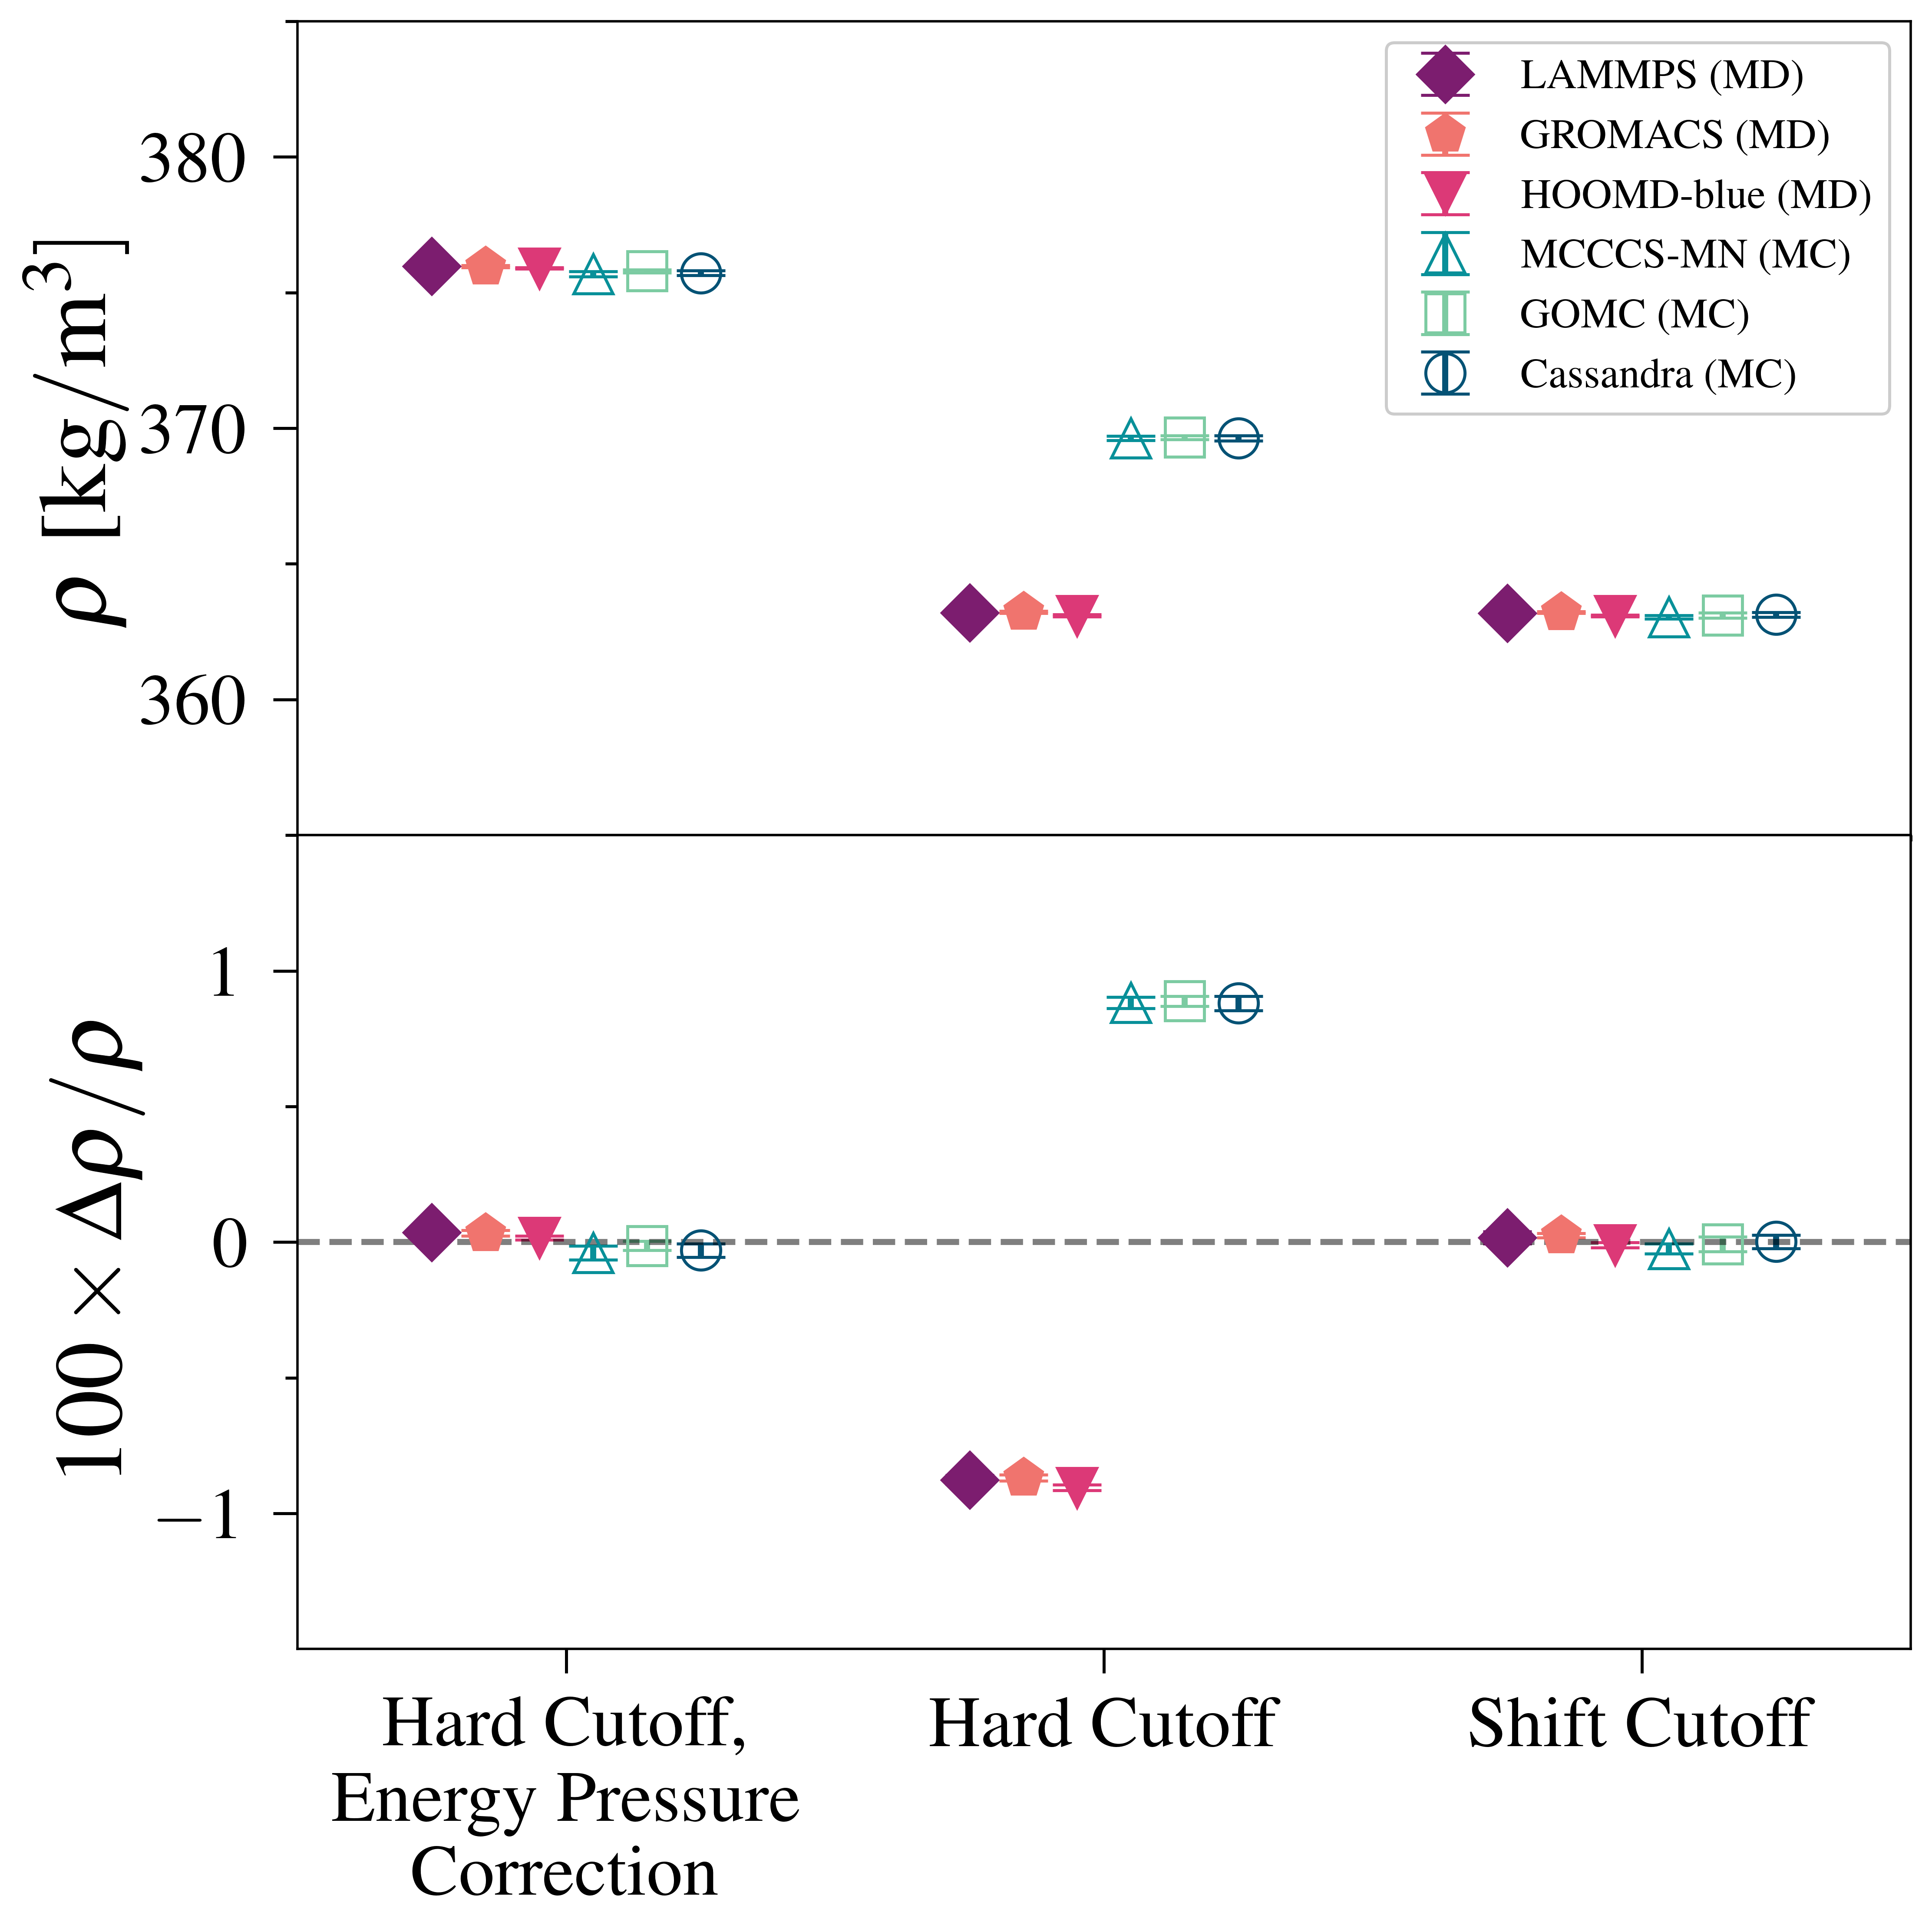

waterSPCE
hard, energy_pressure
hard, nan
shift, nan


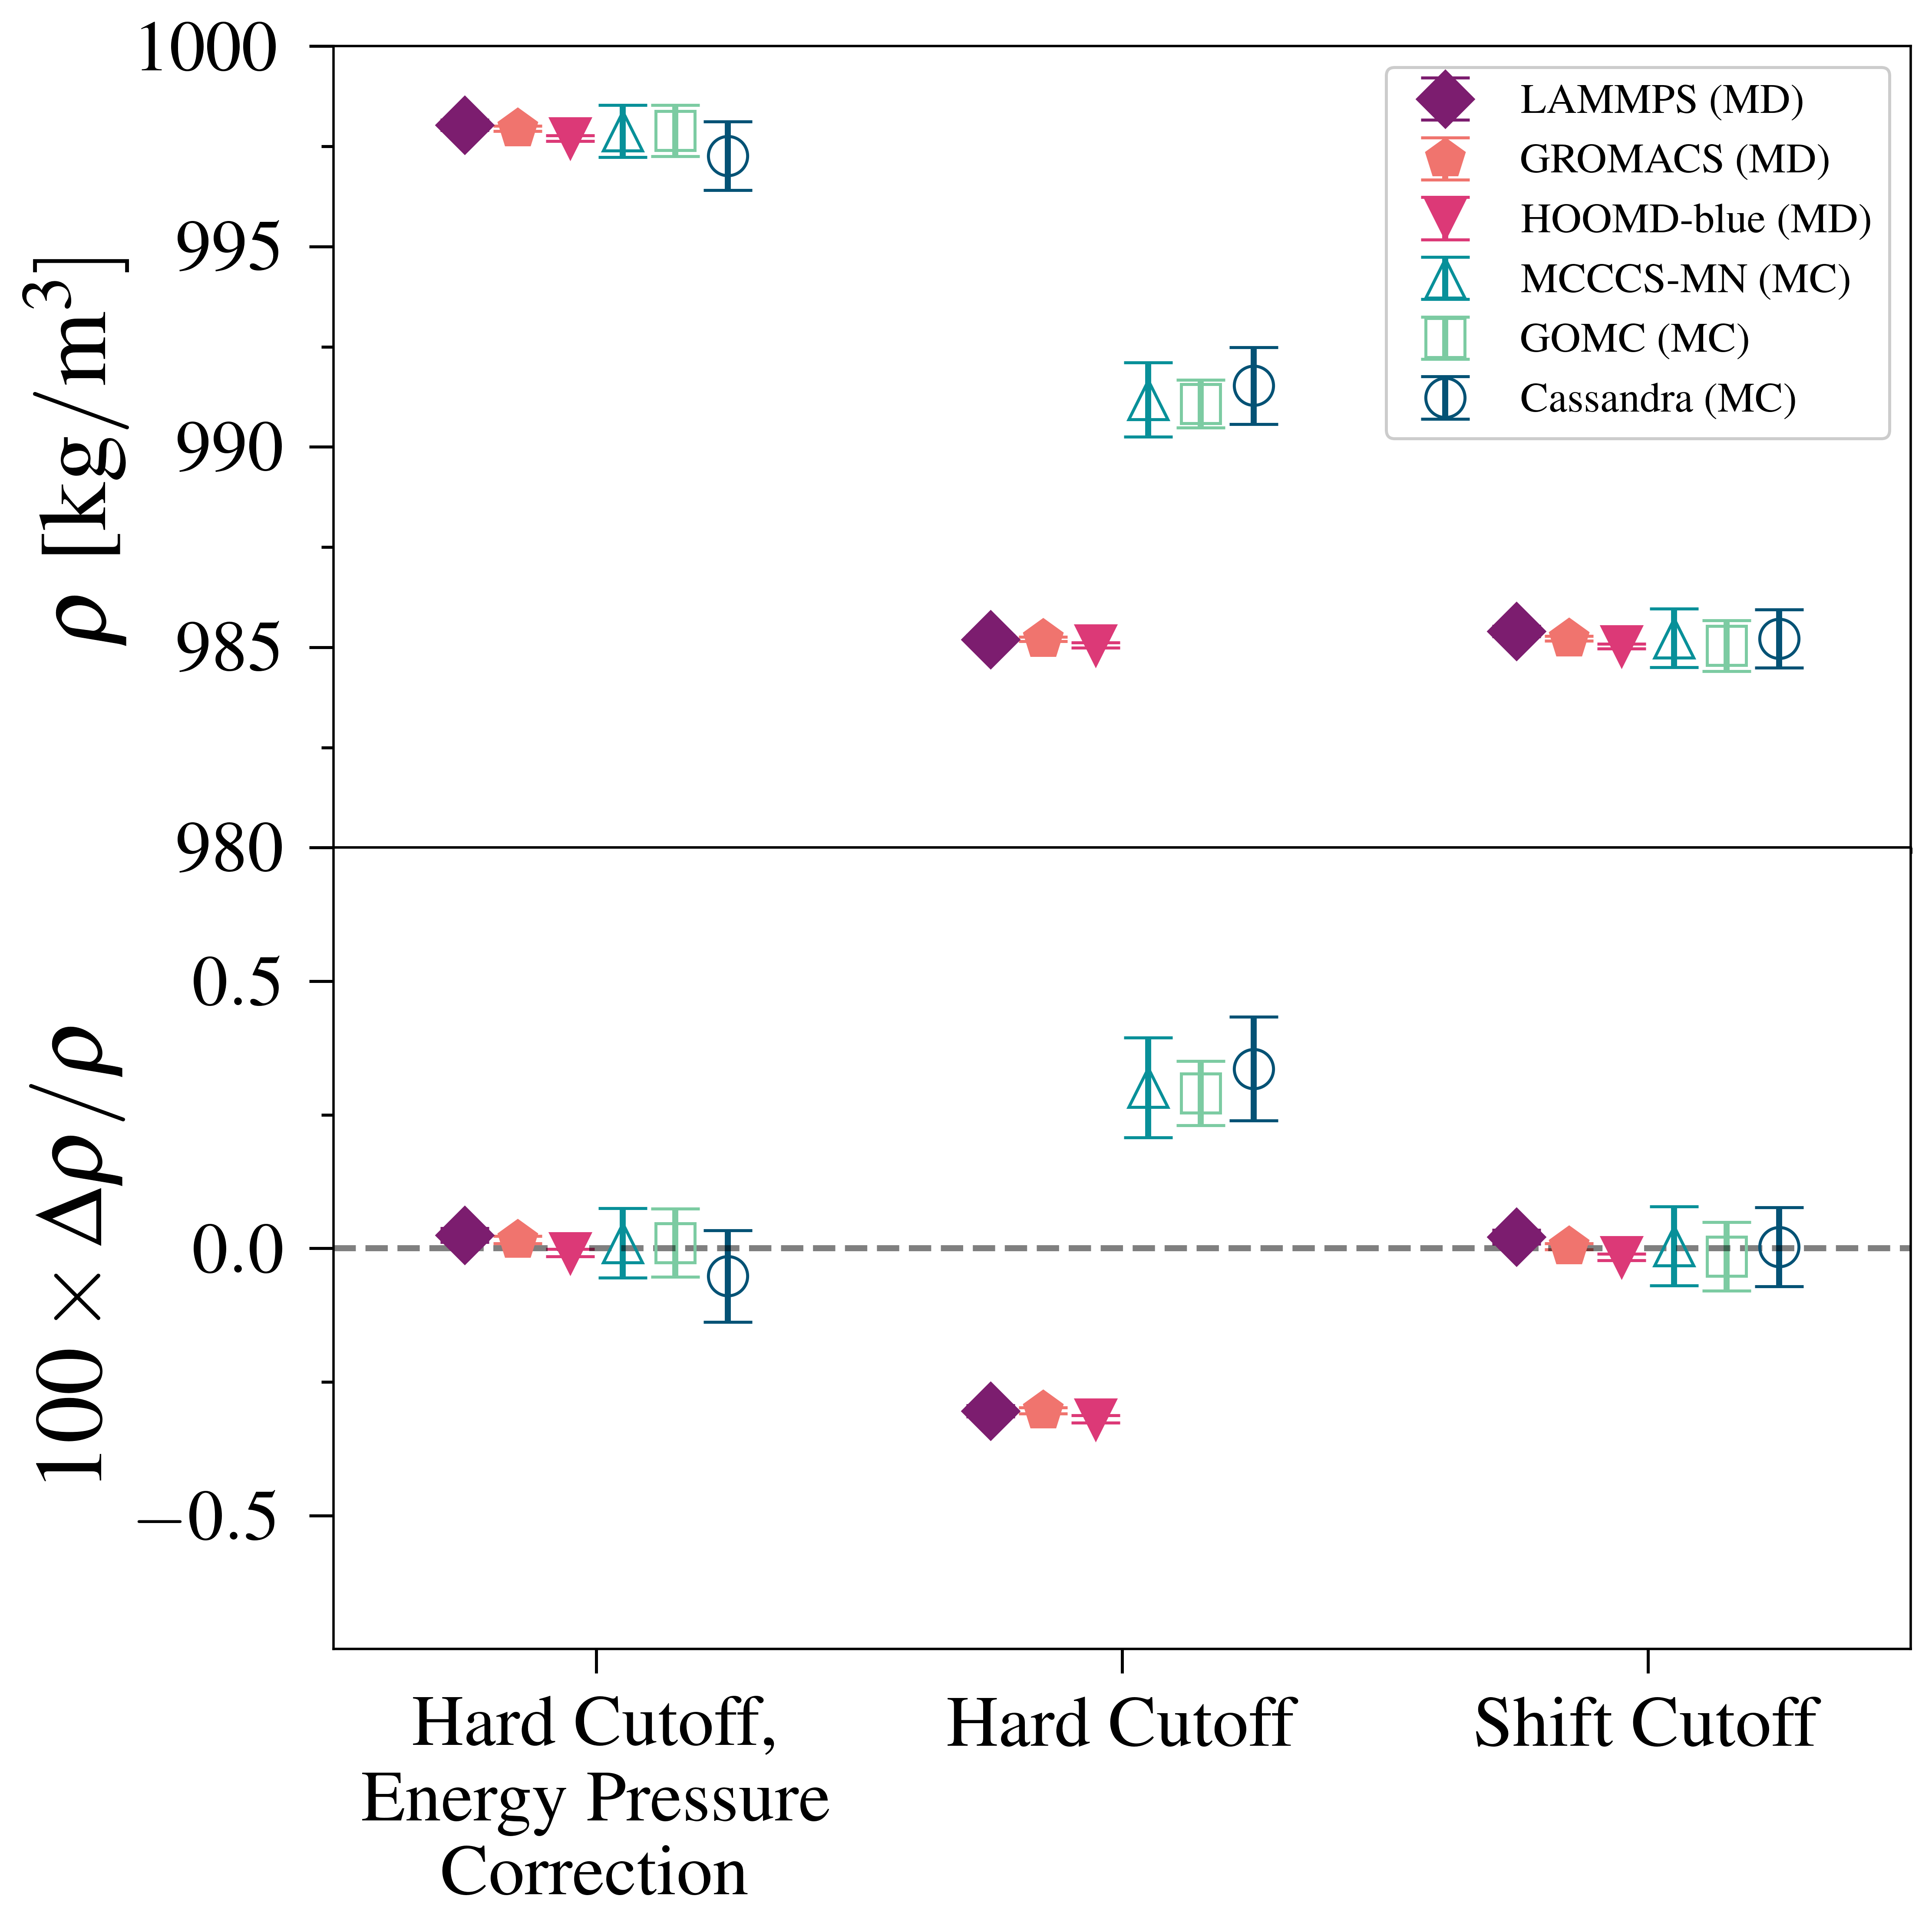

In [36]:
modfigsize = [9, 9]
create_stacked_density_deviation_plots(molecules, all_engine_orders, modfigsize)